# Xception, InceptionV3, and ResNet50 model on Fashion-MNIST data
### Author: @Zihan993
### Date: 11th Aug 2017

In [15]:
################## Import Library ###################################################################
import numpy as np
import time
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import itertools
# from keras.optimizers import Adam


## 1. Define Hyper-parameters

In [2]:
################## Hyper-parameters ###################################################################
## Example of trainining a CNN on classes 1,2,3,8,9
# input image dimensions
img_rows, img_cols = 28, 28
#set CNN parameters
batch_size = 64
num_classes = 10
epochs = 50
FC_SIZE = 256
rotation_range = 30
width_shift_range = 0.2
height_shift_range = 0.2
new_img_rows, new_img_cols = 224, 224

## 2. Load Fashion-MNIST data

In [3]:
################## Load data ###################################################################
# read training and test sets
data=np.load("C:/Users/20171209/Documents/Data Mining Module/CodeExampleAndFashionDataset/FashionData/FashionPDEngDM.npz")

##Labeled training set for classes 1,2,3,8,9 (30000 samples)
x_train_12389_labeled=data["x_train_12389_labeled"]
y_train_12389_labeled=data["y_train_12389_labeled"]

##Labeled training set for classes 0,4,5,6,7 (just 5 samples)
x_train_04567_labeled=data["x_train_04567_labeled"]
y_train_04567_labeled=data["y_train_04567_labeled"]

##Unlabeled training set for classes 0,4,5,6,7 (29992 samples)
x_train_04567_unlabeled=data["x_train_04567_unlabeled"]

##Labeled test set for classes 1,2,3,8,9
x_test_12389=data["x_test_12389"]
y_test_12389=data["y_test_12389"]

##Labeled test set for classes 0,4,5,6,7 (this is where we are interested to obtain the highest accuracy possible - project goal)
x_test_04567=data["x_test_04567"]
y_test_04567=data["y_test_04567"]


## 3. Pre-processing (resize + convert to RGB)

In [4]:
################## Pre-processing ###################################################################
def resize_RGB (img, output_shape = (224, 224)):

    img = img.reshape(28,28)
    img = Image.fromarray(img)
    img = img.resize(output_shape, PIL.Image.ANTIALIAS)
    #img = np.array(img)
    img = np.stack((img,)*3, axis=2)
    
    return img

x_train_12389_labeled = [resize_RGB(img) for img in x_train_12389_labeled]
x_train_12389_labeled = np.asarray(x_train_12389_labeled)
                        
x_test_12389 = [resize_RGB(img) for img in x_test_12389]
x_test_12389 = np.asarray(x_test_12389)

x_train_04567_labeled = [resize_RGB(img) for img in x_train_04567_labeled]
x_train_04567_labeled = np.asarray(x_train_04567_labeled)

x_test_04567 = [resize_RGB(img) for img in x_test_04567]
x_test_04567 = np.asarray(x_test_04567)

#x_train_12389_labeled = x_train_12389_labeled.astype('float32') / 255
y_train_12389_labeled = keras.utils.to_categorical(y_train_12389_labeled, num_classes)

#x_test_12389 =  x_test_12389.astype('float32') / 255
y_test_12389 = keras.utils.to_categorical(y_test_12389, num_classes)

#x_train_04567_labeled = x_train_04567_labeled.astype('float32') / 255
y_train_04567_labeled = keras.utils.to_categorical(y_train_04567_labeled, num_classes)

#x_test_04567 = x_test_04567.astype('float32') / 255
y_test_04567 = keras.utils.to_categorical(y_test_04567, num_classes)

(224, 224, 3)


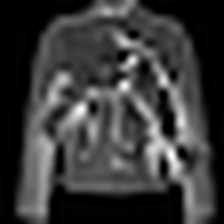

In [5]:
print(x_train_12389_labeled[0].shape)
Image.fromarray(x_train_12389_labeled[0], 'RGB')

## 4. Load Model (Xception, InceptionV3, or ResNet50)

In [8]:
################## VGG model ###################################################################
#model = keras.applications.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling=None, classes=1000)
model = keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling=None, classes=1000)
#model = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling=None, classes=1000)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

## 5. Transfer Learning

In [9]:
################## Transfer learning ###################################################################
#inputs = Input(shape = input_shape)
#y = model(inputs)
model.layers.pop()

for layer in model.layers:
    layer.trainable = False #turn off all layers for training

# model.layers[1].trainable = True

# adding a dense layer behind flatten_1 layers (i.e., layer[-4])
#x = Dense(128, activation='relu', name = "dense_new1")(model.layers[-4].output)
#x = Dropout(0.5, name='dropout_new')(x)
predictions = Dense(num_classes, activation='softmax', name='softmax_new1')(model.layers[-1].output)  # new softmax layer
transfer_model = Model(input=model.input, output=predictions)
#transfer_model.summary()

transfer_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

C:\Users\20171209\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("so...)`


## 6. Data Augmentation

In [10]:
################## Data augmentation ###################################################################
datagen = ImageDataGenerator(
    rotation_range = rotation_range,
    width_shift_range = width_shift_range,
    height_shift_range = height_shift_range)
datagen.fit(x_train_04567_labeled)

train_generator = datagen.flow(x_train_04567_labeled, y_train_04567_labeled, batch_size = 64, save_to_dir='C:/Users/20171209/Documents/Data Mining Module/results/augmentation')

tic = time.clock()
transfer_model.fit_generator(train_generator,
                    steps_per_epoch= 5,
                    epochs=epochs,
                    shuffle = True,
                    verbose = 0)
toc = time.clock()
toc-tic

194.4833418271605

## 7. Model Evaluation

In [11]:
tic = time.clock()

score = transfer_model.evaluate(x_test_04567, y_test_04567, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

toc = time.clock()
toc-tic

Test loss: 1.15180075569
Test accuracy: 0.5526


760.379454419753

## 8. Visualize the Confusion Matrix

In [12]:
np.set_printoptions(precision=2)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
       
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
y_predict = transfer_model.predict(x_test_04567)
y_predict = np.argmax(y_predict, axis = 1)
#y_predict = transfer_model.predict_classes(x_test_04567)
target_names = ['T-shirt/Top', 'Coat', 'Sandal', 'Shirt', 'Sneaker']
print(classification_report(np.argmax(y_test_04567, axis = 1), y_predict, target_names = target_names))
cm = confusion_matrix(np.argmax(y_test_04567, axis = 1), y_predict)

plt.figure()
plot_confusion_matrix(cm, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## 9. Accuracy on the testing set:

### Xception: 63%

### InceptionV3: 55%

### ResNet50:  58%
